In [749]:
#Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mode
from sklearn.preprocessing import Imputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import XGBClassifier, plot_importance
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score
%matplotlib inline

In [750]:
#Reading single input file
df_file = pd.read_csv("../Documents/JK/CKD/CKD_Train.csv")

In [751]:
#Separating known and unknown dataset
df = df_file[np.isfinite(df_file['CKD'])]
df_test = df_file[df_file.CKD.isnull()]

In [752]:
#Cleaning junk values and reseting index
df_test = df_test.dropna(how='all')
df_test = df_test.reset_index(drop=True)

In [753]:
#Back up for transformation - later on
df_bkp = df
df_test_bkp = df_test

In [754]:
print df.shape, df_test.shape

(6000, 34) (2819, 34)


In [755]:
#Define a generic function using Pandas replace function
def coding(col, codeDict):
    colCoded = pd.DataFrame(col, copy=True)
    for key, value in codeDict.items():
        colCoded.replace(key, value, inplace=True)
    return colCoded

In [756]:
#Remove ID fields and separate Target
df_Y = df['CKD']
df = df.drop(['CKD','ID'], axis =1)

In [757]:
print df.shape, df_Y.shape

(6000, 32) (6000,)


In [758]:
#Filter columns into numerical & categorical
df_num = df.select_dtypes(include=[np.number]) #Numbers which are categories must be verified
df_cat = df.select_dtypes(exclude=[np.number])
print df_num.shape, df_cat.shape

(6000, 30) (6000, 2)


In [759]:
#Function to check % of missing values
def missing_values_table(df): 
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum()/len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    return mis_val_table_ren_columns

In [760]:
#Function to eliminate variables with more than 99% missing values - need function 'missing_values_table'
def non_missing_col(df):
    df_col = missing_values_table(df) #Calc missing values for each column
    df_col = df_col.loc[df_col['% of Total Values'] <= 99] #Filter dataframe with less missing values
    df_col = df_col.index.values.tolist() #Convert dataframe to columns list
    return df_col

In [761]:
#Eliminate Categorical Variables with more than 99% missing values
df_cat_col = missing_values_table(df_cat)
df_elim_col = df_cat_col.loc[df_cat_col['% of Total Values'] > 99]
df_elim_col = df_elim_col.index.values.tolist()
df_elim = df_cat[df_elim_col]

In [762]:
#Verify whether eliminated categorical fields have 100% correlation
df_elim = df_elim.join(df_Y)
print df_elim.shape

(6000, 1)


In [763]:
#Numerical variables with LT 99% missing values
df_num_col = non_missing_col(df_num)
df_num = df_num[df_num_col]
#Categorical variables with LT 99% missing values
df_cat_col = non_missing_col(df_cat)
df_cat = df_cat[df_cat_col]
print df_num.shape, df_cat.shape

(6000, 30) (6000, 2)


In [764]:
#Find Count of distinct values in categorical fields
count = df_cat.apply(pd.Series.nunique)
dstnct_cnt_col = pd.DataFrame(count, columns=['count'])
# dstnct_cnt_col

In [765]:
#Binary Variables(1 or 2)
df_binary_col = dstnct_cnt_col.loc[dstnct_cnt_col['count'] <=2]
df_binary_col = df_binary_col.index.values.tolist()
df_binary = df_cat[df_binary_col]
#Nominal Variables(2+)
df_nominal_col = dstnct_cnt_col.loc[dstnct_cnt_col['count'] >2]
df_nominal_col = df_nominal_col.index.values.tolist()
df_nominal = df_cat[df_nominal_col]

In [766]:
#EDA plots - 1 
#Univariate analysis - Checking distribution of binary variables
for i in df_binary_col:
    fig, ax = plt.subplots()
    fig.set_size_inches(12, 9)
    sns.countplot(x=i, data=df_cat);
    plt.show()

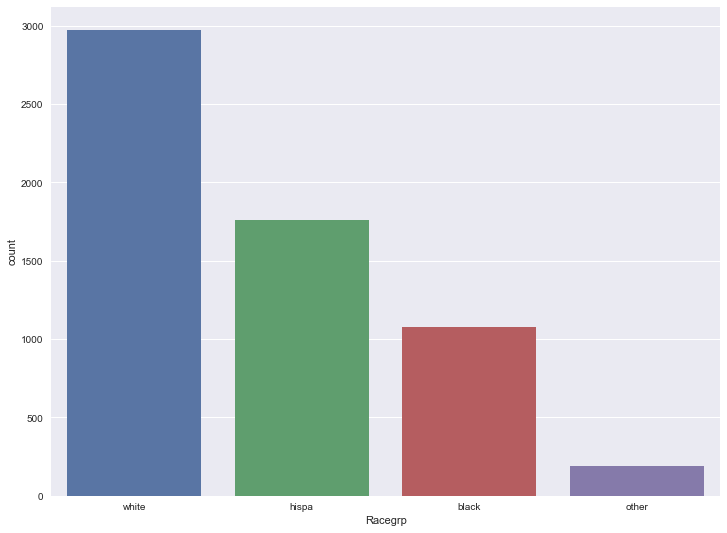

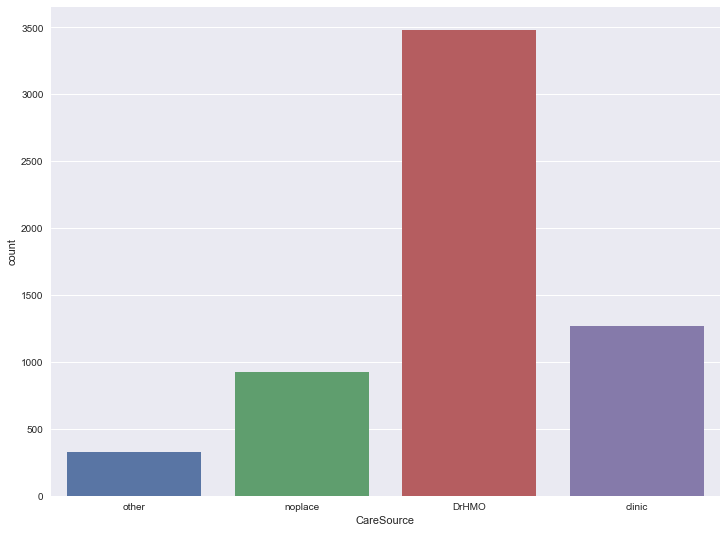

In [767]:
#EDA plots - 2 
#Univariate analysis - Checking distribution of nominal variables
for i in df_nominal_col:
    fig, ax = plt.subplots()
    fig.set_size_inches(12, 9)
    sns.countplot(x=i, data=df_cat);
    plt.show()

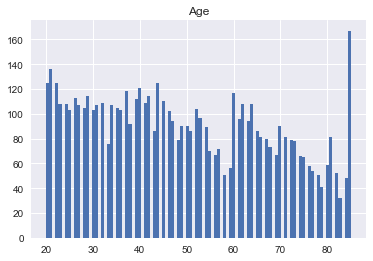

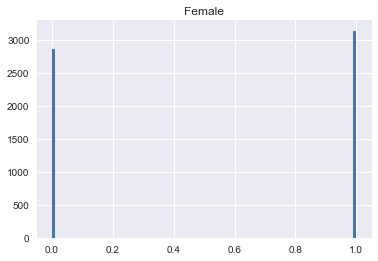

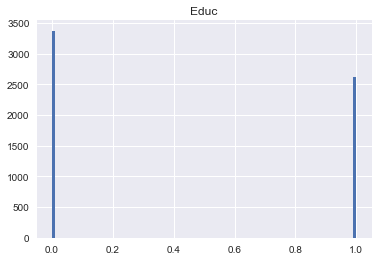

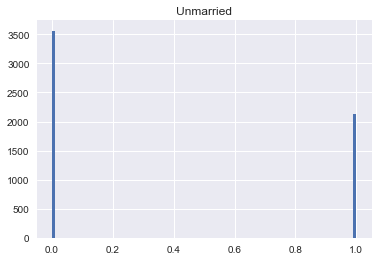

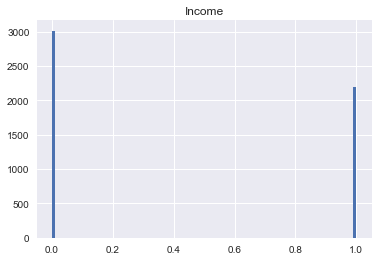

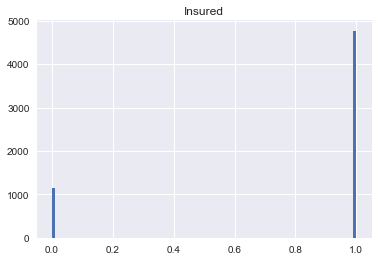

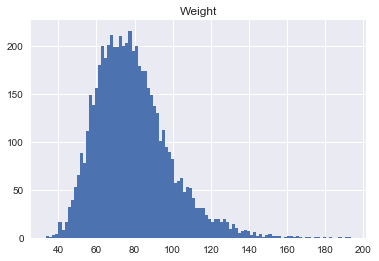

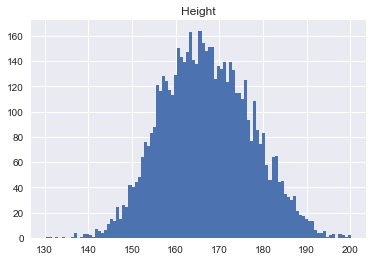

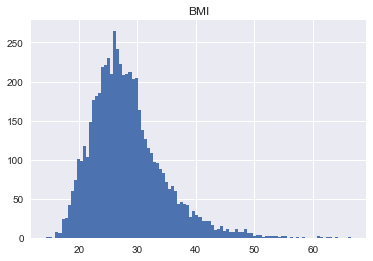

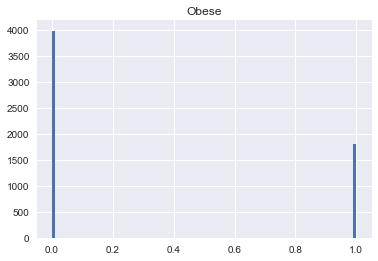

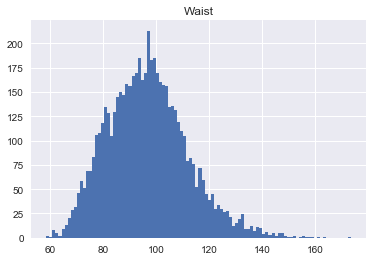

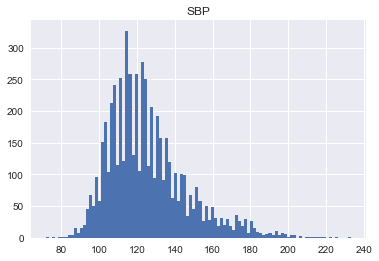

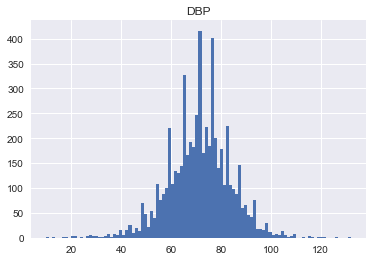

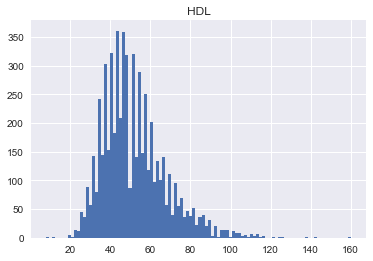

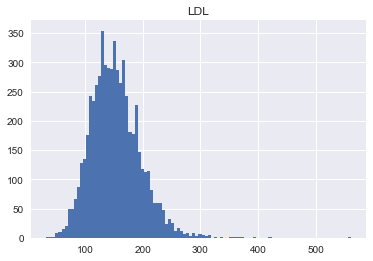

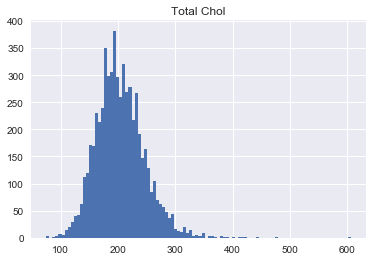

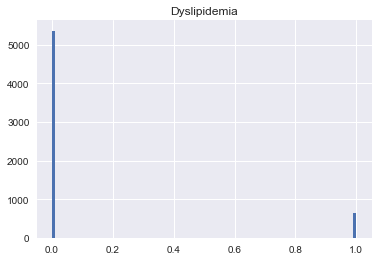

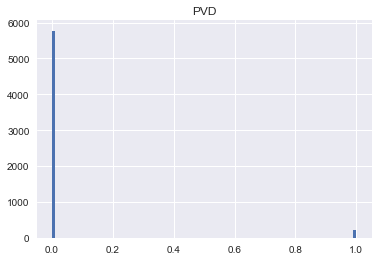

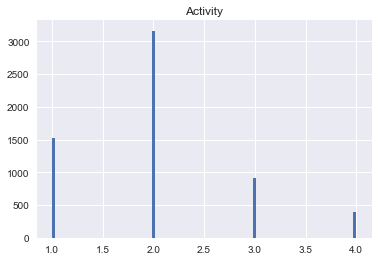

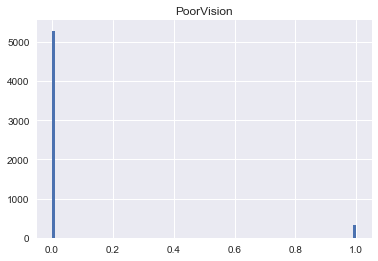

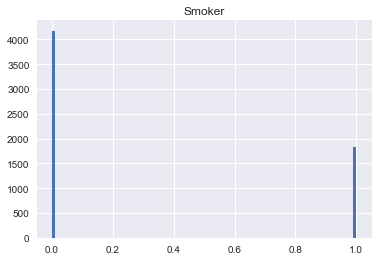

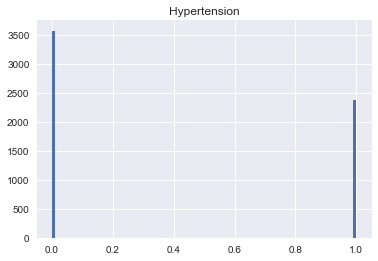

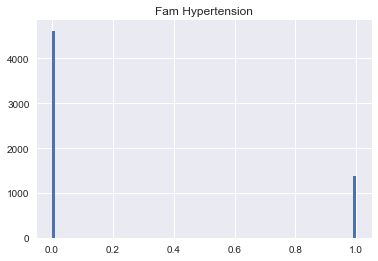

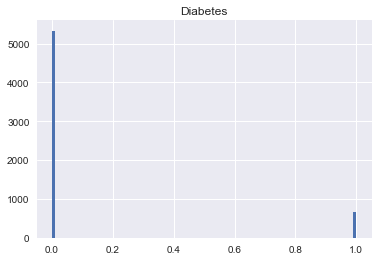

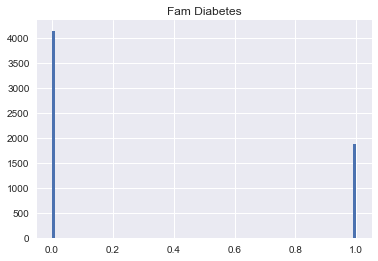

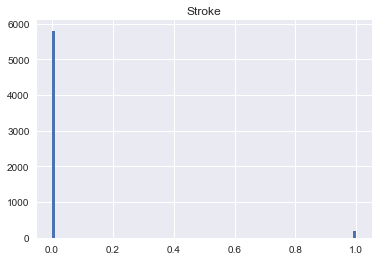

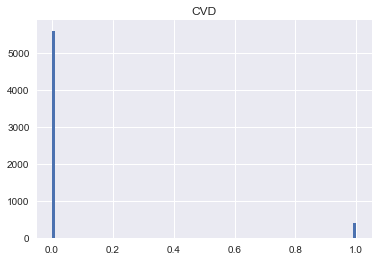

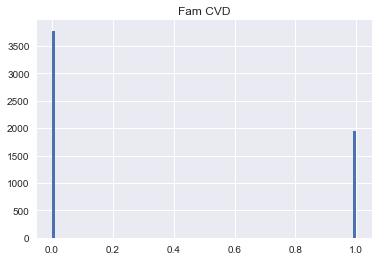

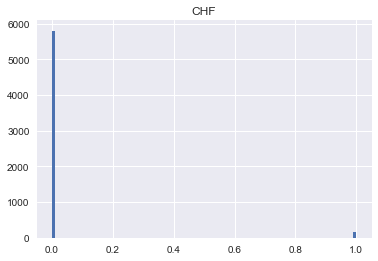

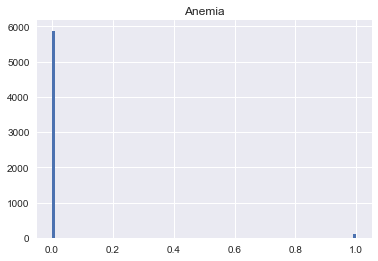

In [768]:
#EDA plots - 3
#Univariate analysis - Checking distribution of numerical variables using histogram
for i in df_num_col:
    df_num.hist(column=i, bins = 100)
    plt.show()

In [769]:
df = df_bkp

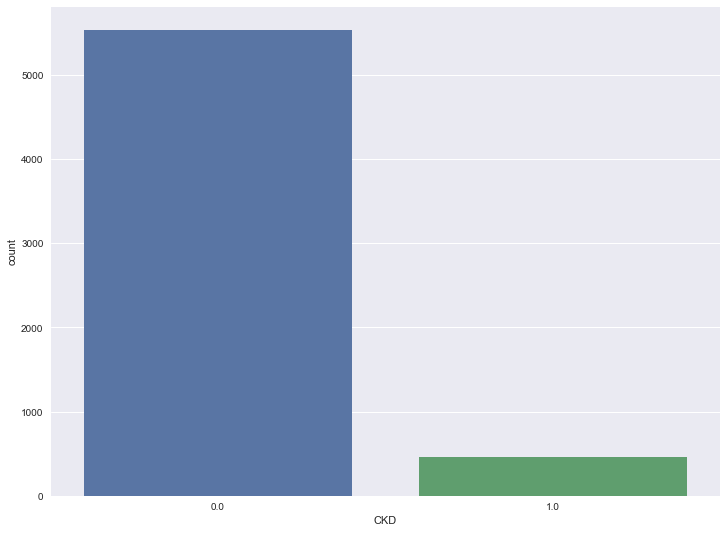

In [770]:
#EDA plots - 4
#Target distribution
df_Y_col = df_Y.index.values.tolist()
fig, ax = plt.subplots()
fig.set_size_inches(12, 9)
sns.countplot(x = df_Y_col, data=df_Y);
plt.show()

In [771]:
#EDA - 5 Bi-variate analysis on binary variables
for i in df_binary_col:
    fig, ax = plt.subplots()
    fig.set_size_inches(12, 9)
    sns.countplot(x=i, data=df, hue='CKD')
    plt.show()

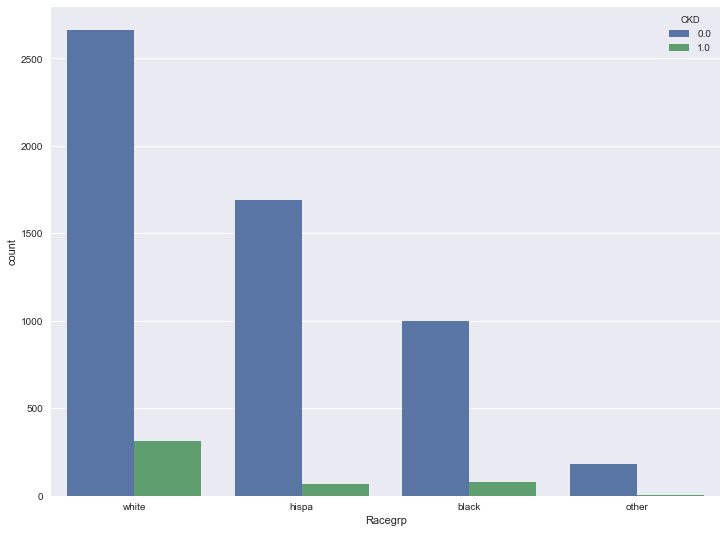

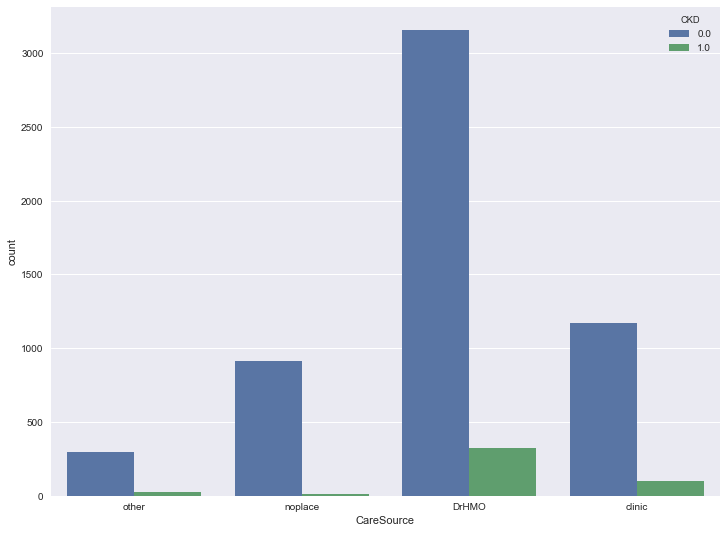

In [772]:
#EDA - 6 Bi-variate analysis on nominal variables
for i in df_nominal_col:
    fig, ax = plt.subplots()
    fig.set_size_inches(12, 9)
    sns.countplot(x=i, data=df, hue='CKD')
    plt.show()

In [773]:
df.groupby('CareSource').count().reset_index()

,CareSource,ID,Age,Female,Racegrp,Educ,Unmarried,Income,Insured,Weight,...,Hypertension,Fam Hypertension,Diabetes,Fam Diabetes,Stroke,CVD,Fam CVD,CHF,Anemia,CKD
0,DrHMO,3482,3482,3482,3482,3471,3317,3042,3441,3401,...,3478,3482,3482,3482,3480,3477,3305,3464,3481,3482
1,clinic,1269,1269,1269,1269,1267,1198,1119,1259,1241,...,1258,1269,1269,1269,1267,1263,1222,1264,1267,1269
2,noplace,925,925,925,925,923,880,782,907,912,...,891,925,925,925,925,925,884,924,925,925
3,other,324,324,324,324,324,304,265,315,313,...,320,324,323,324,322,322,306,322,324,324


In [774]:
df_test.groupby('CareSource').count().reset_index()

,CareSource,ID,Age,Female,Racegrp,Educ,Unmarried,Income,Insured,Weight,...,Hypertension,Fam Hypertension,Diabetes,Fam Diabetes,Stroke,CVD,Fam CVD,CHF,Anemia,CKD
0,DrHMO,1641,1641,1641,1641,1640,1553,1439,1622,1600,...,1638,1641,1641,1641,1638,1636,1564,1637,1639,0
1,clinic,604,604,604,604,602,571,521,598,594,...,601,604,604,604,603,600,569,599,604,0
2,noplace,428,428,428,428,426,404,360,421,421,...,407,428,428,428,428,428,414,428,427,0
3,other,146,146,146,146,146,140,125,143,143,...,146,146,145,146,145,145,136,145,146,0


In [775]:
df.CareSource.unique()

array(['other', 'noplace', 'DrHMO', 'clinic'], dtype=object)

In [776]:
df.loc[~df['CareSource'].isin(['other','noplace','DrHMO','clinic'])]

,ID,Age,Female,Racegrp,Educ,Unmarried,Income,CareSource,Insured,Weight,...,Hypertension,Fam Hypertension,Diabetes,Fam Diabetes,Stroke,CVD,Fam CVD,CHF,Anemia,CKD


In [777]:
df = df_bkp

In [778]:
df_test = df_test_bkp

In [779]:
Cust_id_test = df_test[['ID']]

In [780]:
print df.shape, df_test.shape

(6000, 34) (2819, 34)


In [781]:
# #training Target
# df_train = df
# train_Y = df_train ['CKD']
# df_train = df_train.drop(['CKD'], axis =1)
# df_train = df_train[imp_features]
# print df_train.shape

In [782]:
# n_folds = 5
# early_stopping = 10

In [783]:
# params = {'eta': 0.02, 'max_depth': 3, 'subsample': 0.7, 'colsample_bytree': 0.7, 'objective': 'binary:logistic', 'seed': 99, 'silent': 1, 'eval_metric':'auc', 'nthread':4}
# xg_train = xgb.DMatrix(df_train, label=train_Y)

In [784]:
# cv = xgb.cv(params, xg_train, 5000, nfold=n_folds, early_stopping_rounds=early_stopping, verbose_eval=1)

In [786]:
# cv

In [787]:
#Training_Validation Split
df_train, df_validation = train_test_split(df,test_size=0.20,random_state=190)
print "Train shape : ",df_train.shape
print "Validation shape : ",df_validation.shape

Train shape :  (4800, 34)
Validation shape :  (1200, 34)


In [788]:
#training Target
train_Y = df_train ['CKD']
validation_Y = df_validation ['CKD']
print train_Y.shape, validation_Y.shape

(4800,) (1200,)


In [789]:
df_train = df_train.drop(['CKD'], axis =1)
df_validation = df_validation.drop(['CKD'], axis =1)
print "Train shape : ",df_train.shape
print "Validation shape : ",df_validation.shape

Train shape :  (4800, 33)
Validation shape :  (1200, 33)


In [790]:
imp_features

['LDL',
 'SBP',
 'Height',
 'Age',
 'Weight',
 'Waist',
 'Total Chol',
 'HDL',
 'BMI',
 'DBP',
 'Activity',
 'Hypertension']

In [792]:
df_train = df_train[imp_features]
df_validation = df_validation[imp_features]
df_test = df_test[imp_features]

In [793]:
print df_train.shape, df_validation.shape, df_test.shape

(4800, 12) (1200, 12) (2819, 12)


In [795]:
# df_train_num = df_train[df_num_col]
# df_validation_num = df_validation[df_num_col]
# df_test_num = df_test[df_num_col]

In [796]:
# print df_train_num.shape, df_validation_num.shape, df_test_num.shape

In [798]:
# df_train_num = df_train[df_num_col]
# df_validation_num = df_validation[df_num_col]
# df_test_num = df_test[df_num_col]

In [800]:
# print df_train_num.shape, df_validation_num.shape, df_test_num.shape

In [483]:
# #Impute median values for numerical variables
# def impute_median(df):
#     fill_NaN = Imputer(missing_values=np.nan, strategy='median', axis=1)
#     imputed_df = pd.DataFrame(fill_NaN.fit_transform(df))
#     imputed_df.columns = df.columns
#     imputed_df.index = df.index
#     return imputed_df

In [484]:
# imputed_df_train_num = impute_median(df_train_num)
# imputed_df_validation_num = impute_median(df_validation_num)
# imputed_df_test_num = impute_median(df_test_num)

In [485]:
# print imputed_df_train_num.shape, imputed_df_validation_num.shape, imputed_df_test_num.shape

(4800, 30) (1200, 30) (2819, 30)


In [265]:
# #PCA function with normalization
# def doPCAwS(df_train, df_validation, df_test, n):
#     #Create index dataframe to join later
#     df_train_idx = df_train.index.values.tolist()
#     df_train_idx = pd.DataFrame(df_train_idx).rename(columns = {0 : 'idx'})
#     df_validation_idx = df_validation.index.values.tolist()
#     df_validation_idx = pd.DataFrame(df_validation_idx).rename(columns = {0 : 'idx'})
#     df_test_idx = df_test.index.values.tolist()
#     df_test_idx = pd.DataFrame(df_test_idx).rename(columns = {0 : 'idx'})
#     #Scaling the values - Normalize/Standardize
#     X_train = scale(df_train)
#     X_validation = scale(df_validation)
#     X_test = scale(df_test)
#     #Calling PCA function and fitting
#     pca = PCA(n_components=n)
#     pca.fit(X_train)
#     #The amount of variance that each PC explains
#     var = pca.explained_variance_ratio_
#     #Cumulative Variance explains
#     cum_var=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
#     print cum_var
#     #Transform into PCs
#     X_train_tfm = pca.fit_transform(X_train)
#     df_train_pca = pd.DataFrame(X_train_tfm)
#     X_validation_tfm = pca.transform(X_validation)
#     df_validation_pca = pd.DataFrame(X_validation_tfm)
#     X_test_tfm = pca.fit_transform(X_test)
#     df_test_pca = pd.DataFrame(X_test_tfm)
#     #Join Index with non-PCA columns
#     df_train_pca = df_train_idx.join(df_train_pca).set_index(['idx'])
#     df_validation_pca = df_validation_idx.join(df_validation_pca).set_index(['idx'])
#     df_test_pca = df_test_idx.join(df_test_pca).set_index(['idx'])
#     del df_train_pca.index.name, df_validation_pca.index.name, df_test_pca.index.name
#     return df_train_pca, df_validation_pca, df_test_pca

In [486]:
# df_train_num_pca, df_validation_num_pca, df_test_num_pca = doPCAwS(imputed_df_train_num,imputed_df_validation_num,imputed_df_test_num,18)

[ 11.66  21.27  28.05  34.33  39.91  45.21  50.1   54.37  58.05  61.49
  64.8   68.06  71.22  74.16  76.92  79.58  82.21  84.63]


In [267]:
# df_train_num_pca = df_train_num_pca.add_prefix('numPCA_')
# df_validation_num_pca = df_validation_num_pca.add_prefix('numPCA_')
# df_test_num_pca = df_test_num_pca.add_prefix('numPCA_')

In [268]:
# print df_train_num_pca.shape, df_validation_num_pca.shape, df_test_num_pca.shape

(4800, 18) (1200, 18) (2819, 18)


In [487]:
# #Handling Categorical variables
# df_train_nominal = df_train[df_nominal_col]
# df_validation_nominal = df_validation[df_nominal_col]
# df_test_nominal = df_test[df_nominal_col]

In [488]:
# def impute_mode(df):
#     imputed_df = df.apply(lambda x:x.fillna(x.value_counts().index[0]))
#     return imputed_df

In [489]:
# imputed_df_train_nominal = impute_mode(df_train_nominal)
# imputed_df_validation_nominal = impute_mode(df_validation_nominal)
# imputed_df_test_nominal = impute_mode(df_test_nominal)

In [490]:
# #Function to creating dummy variables for Nominal fields for a set of columns
# def create_dummy_set(df_col,df):
#     for i in df_col:
#         dummies = pd.get_dummies(df[i]).rename(columns=lambda x: i+'_'+ str(x))
#         #Adding to input variables
#         df = pd.concat([df, dummies], axis=1)
#         #Dropping column without having to reassign
#         df.drop([i], inplace=True, axis=1)
#         print df.shape
#     return df

In [491]:
# df_train_nominal = create_dummy_set(df_nominal_col,imputed_df_train_nominal)
# df_validation_nominal = create_dummy_set(df_nominal_col,imputed_df_validation_nominal)
# df_test_nominal = create_dummy_set(df_nominal_col,imputed_df_test_nominal)

(4800, 5)
(4800, 8)
(1200, 5)
(1200, 8)
(2819, 5)
(2819, 8)


In [492]:
# print df_train_num_pca.shape, df_train_nominal.shape, train_Y.shape
# print df_validation_num_pca.shape, df_validation_nominal.shape, validation_Y.shape
# print df_test_num_pca.shape, df_test_nominal.shape

(4800, 18) (4800, 8) (4800,)
(1200, 18) (1200, 8) (1200,)
(2819, 18) (2819, 8)


In [493]:
# df_train = df_train_num_pca.join(df_train_nominal)
# df_validation = df_validation_num_pca.join(df_validation_nominal)
# df_test = df_test_num_pca.join(df_test_nominal)

In [494]:
# df_train = imputed_df_train_num.join(df_train_nominal)
# df_validation = imputed_df_validation_num.join(df_validation_nominal)
# df_test = imputed_df_test_num.join(df_test_nominal)

In [801]:
# print df_train.shape, df_validation.shape, df_test.shape

(4800, 12) (1200, 12) (2819, 12)


In [804]:
# rf = RandomForestClassifier(n_estimators=450, max_features=15, max_depth=10, n_jobs=2).fit(df_train,train_Y)
# train_pred = rf.predict_proba(df_train)
# val_pred = rf.predict_proba(df_validation)

In [805]:
# train_pred_val = rf.predict(df_train)
# val_pred_val = rf.predict(df_validation)
# print confusion_matrix(train_Y, train_pred_val)
# print confusion_matrix(validation_Y, val_pred_val)
# print accuracy_score(train_Y, train_pred_val)
# print accuracy_score(validation_Y, val_pred_val)
# print recall_score(train_Y, train_pred_val)
# print recall_score(validation_Y, val_pred_val)
# print precision_score(train_Y, train_pred_val)
# print precision_score(validation_Y, val_pred_val)

In [806]:
_xgb = xgb.XGBClassifier(objective='binary:logistic',max_depth=3,n_estimators=500,colsample_bytree=.75,learning_rate=0.06).fit(df_train, train_Y,eval_metric='auc')

[ 0.09208045  0.10182276  0.1052797   0.10496543  0.10842238  0.08736644
  0.07950974  0.09899434  0.09930861  0.07825267  0.02199874  0.02199874]


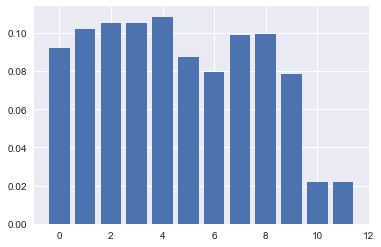

In [807]:
# feature importance
print(_xgb.feature_importances_)
# plot
plt.bar(range(len(_xgb.feature_importances_)), _xgb.feature_importances_)
plt.show()

In [808]:
ax = plot_importance(_xgb, max_num_features=50, ax=ax)
fig = ax.figure
fig.set_size_inches(18.5, 10.5)
fig.savefig('../Documents/JK/CKD/CKD_imp_features.png', dpi=1000)
plt.show()

In [809]:
imp_features = ["LDL","SBP","Height","Age","Weight","Waist","Total Chol","HDL","BMI","DBP","Activity","Hypertension"]

In [810]:
#model training
_xgb = xgb.XGBClassifier(objective='binary:logistic',max_depth=3,n_estimators=500,colsample_bytree=.75,learning_rate=0.06).fit(df_train, train_Y,eval_metric='auc')
train_pred = _xgb.predict_proba(df_train)
val_pred = _xgb.predict_proba(df_validation)

In [811]:
#Using only probability for CKD Positive
train_pred_val = train_pred[:,1]
val_pred_val = val_pred[:,1]

In [812]:
train_pred_val

array([ 0.00271794,  0.00108637,  0.12177316, ...,  0.00129811,
        0.0072551 ,  0.00240793], dtype=float32)

In [813]:
#Setting probability threshold for unbalanced known data
m=0.15
for i in range(len(train_pred_val)):
    if train_pred_val[i]<m:
        train_pred_val[i]=0
    else: 
        train_pred_val[i]=1
for i in range(len(val_pred_val)):
    if val_pred_val[i]<m:
        val_pred_val[i]=0
    else: 
        val_pred_val[i]=1

In [814]:
# train_pred_val

In [819]:
# train_pred_val = _xgb.predict(df_train)
# val_pred_val = _xgb.predict(df_validation)
print confusion_matrix(train_Y, train_pred_val)
print confusion_matrix(validation_Y, val_pred_val)
print accuracy_score(train_Y, train_pred_val)
print accuracy_score(validation_Y, val_pred_val)
print recall_score(train_Y, train_pred_val)
print recall_score(validation_Y, val_pred_val)
print precision_score(train_Y, train_pred_val)
print precision_score(validation_Y, val_pred_val)

[[4055  373]
 [  32  340]]
[[976 132]
 [ 33  59]]
0.915625
0.8625
0.913978494624
0.641304347826
0.476858345021
0.30890052356


In [816]:
test_pred = _xgb.predict_proba(df_test)
# test_pred_val = test_pred[:,1]
test_pred

array([[  9.47500706e-01,   5.24993017e-02],
       [  9.96809304e-01,   3.19067156e-03],
       [  6.97570205e-01,   3.02429795e-01],
       ..., 
       [  9.61105108e-01,   3.88949215e-02],
       [  9.99073684e-01,   9.26319917e-04],
       [  9.93827164e-01,   6.17286377e-03]], dtype=float32)

In [817]:
test_pred_val

array([ 0.0524993 ,  0.00319067,  0.3024298 , ...,  0.03889492,
        0.00092632,  0.00617286], dtype=float32)

In [818]:
#Setting probability threshold assumption (unbalanced) for unknown data
m=0.15
for i in range(len(train_pred_val)):
    if train_pred_val[i]<m:
        train_pred_val[i]=0
    else: 
        train_pred_val[i]=1

In [820]:
df_test_pred = pd.DataFrame(train_pred_val.tolist())

In [827]:
predicted_result = Cust_id_test.join(df_test_pred)

In [828]:
# predicted_result = predicted_result.drop(0, 1)

In [829]:
predicted_result = predicted_result.rename(index=str, columns={0: 1})

In [830]:
predicted_result.head(10)

,ID,1
0,6001,0.0
1,6002,0.0
2,6003,0.0
3,6004,0.0
4,6005,0.0
5,6006,1.0
6,6007,1.0
7,6008,0.0
8,6009,0.0
9,6010,0.0


In [831]:
predicted_result.to_csv("../Documents/JK/CKD/CKD_output.csv",sep=',',index=False)